In [0]:
import gym
import numpy as np
import torch as T
import torch.nn as nn
from torch.distributions import Categorical
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR

ENV_NAME = 'CartPole-v1'
TOTAL_TIMESTEPS = 5e5  # 500k timesteps (frames of experience)
GAMMA = 0.99           # reward discounting coefficient
BATCH_SIZE = 8192      # num transitions in each minibatch
TOTAL_UPDATES = int(TOTAL_TIMESTEPS//BATCH_SIZE)  # weight updates
DEVICE = T.device('cuda' if T.cuda.is_available() else 'cpu')

# Neural Net Definition

In [0]:
class ACTOR(nn.Module):
    def __init__(self, in_shape, num_actions):
        super().__init__()
        # input is uni-dimensional for cartpole
        self.net = nn.Sequential(
            nn.Linear(in_shape, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, num_actions),
        )
    def forward(self, x):
        return self.net(x)

# Main

In [63]:
env = gym.make(ENV_NAME)
in_dim = env.observation_space.shape[0]
policy_dim = env.action_space.n

total_steps = 0
actor = ACTOR(in_dim, policy_dim).to(DEVICE)
optimizer = Adam(actor.parameters(), 5e-3)
scheduler = LambdaLR(optimizer, lambda i: 1 - i / TOTAL_UPDATES)

all_log_rwd = []  # (num_steps, reward)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [64]:
def mk_torch(x):
    x = T.from_numpy(x).float()
    x = x.to(DEVICE)
    return x

for i_update in range(1, TOTAL_UPDATES):
    
    ob = mk_torch(env.reset())
    logps, rwds, advs = [], [], []
    l = 0  # length of episode == score

    for _ in range(BATCH_SIZE):  # collect minibatch
        logits = actor(ob)
        dist = Categorical(logits=logits)
        act = dist.sample()
        logp = dist.log_prob(act)
        ob, rwd, done, info = env.step(act.cpu().numpy())
        ob=mk_torch(ob)
        logps.append(logp)
        rwds.append(rwd)
        l += 1
        total_steps += 1
        if done:
            rwds[-1] = 0
            ob = mk_torch(env.reset())
            all_log_rwd.append((total_steps, l))
            l=0
            # discount episode rewards
            for i in reversed(range(len(rwds)-1)):
                rwds[i] += 0.99 * rwds[i+1]
            advs.extend(rwds)
            rwds = []

    for i in reversed(range(len(rwds)-1)):
        rwds[i] += 0.99 * rwds[i+1]
    advs.extend(rwds)

    # policy gradient
    logps = T.stack(logps).to(DEVICE)
    advs = T.from_numpy(np.stack(advs)).to(DEVICE)
    adv = (advs - advs.mean()) / (advs.std() + 1e-8)
    loss = -(logps * adv).mean()

    # step
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(actor.parameters(), 0.5)
    optimizer.step()
    scheduler.step(i_update)

    # stats
    sma = sum(x[1] for x in all_log_rwd[-100:])/100
    print(f'RWD: {sma}\tL: {loss.item():2f}\t[{total_steps}]')

RWD: 21.81	L: 0.000402	[8192]
RWD: 32.39	L: -0.013759	[16384]
RWD: 44.28	L: -0.011191	[24576]
RWD: 55.66	L: -0.011069	[32768]
RWD: 68.53	L: -0.010843	[40960]
RWD: 81.68	L: -0.003259	[49152]
RWD: 106.43	L: -0.008539	[57344]
RWD: 137.71	L: -0.012814	[65536]
RWD: 150.41	L: -0.002207	[73728]
RWD: 168.35	L: -0.004205	[81920]
RWD: 215.99	L: -0.005476	[90112]
RWD: 253.05	L: -0.003661	[98304]
RWD: 291.13	L: -0.007353	[106496]
RWD: 321.26	L: -0.011692	[114688]
RWD: 316.64	L: -0.005049	[122880]
RWD: 313.37	L: -0.013514	[131072]
RWD: 317.07	L: -0.005863	[139264]
RWD: 336.72	L: -0.008898	[147456]
RWD: 358.31	L: -0.010199	[155648]
RWD: 379.41	L: -0.007397	[163840]
RWD: 390.95	L: -0.015681	[172032]
RWD: 399.53	L: -0.010039	[180224]
RWD: 389.69	L: -0.013091	[188416]
RWD: 377.72	L: -0.019477	[196608]
RWD: 382.31	L: -0.016575	[204800]
RWD: 380.71	L: -0.014415	[212992]
RWD: 394.14	L: -0.009376	[221184]
RWD: 411.59	L: -0.006193	[229376]
RWD: 424.19	L: 0.005866	[237568]
RWD: 395.47	L: 0.000905	[245760]
RW

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.ticker as ticker
sns.set()

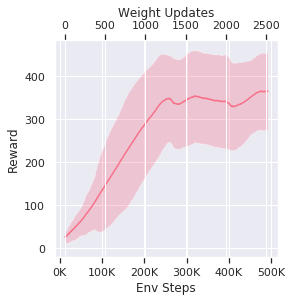

In [94]:
# compute rolling avg and std
df = pd.DataFrame(all_log_rwd, columns =['Frames', 'Reward'])
sma_y = df['Reward'].rolling(500).mean()
std_y = df['Reward'].rolling(500).std()

# plot with seaborn
fig, ax = plt.subplots(figsize=(4,4))
ax2 = ax.twiny()
ax.set_xlabel('Env Steps')
ax.set_ylabel('Reward')
clrs = sns.color_palette("husl", 8)

# fill standard deviation
ax.plot(df['Frames'], sma_y, c=clrs[0])
ax.fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                alpha=0.3, facecolor=clrs[0]) 

# make x axis nice
xlabels = [f'{int(x)}K' for x in ax.get_xticks()/1e3]
ax.set_xticklabels(xlabels)

ax2.plot(range(len(all_log_rwd)), np.ones(len(all_log_rwd)), alpha=0) # Create a dummy plot
ax2.set_xlabel('Weight Updates')

plt.savefig('cartpole_fig_reinforce.png', dpi=300, pad_inches=0, bbox_inches = 'tight')
plt.show()

In [0]:
from google.colab import files

files.download('cartpole_fig_reinforce.png')